In [97]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [98]:
%cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [99]:
%ls

 barcode_search_results.json         data/
 barTPvsFP.png                       PMSU/
 barTPvsFPRelRank.png                Staršie/
 BDP/                                synthetic_search_results.json
'Copy of BDP_jozef'                  syntTPvsFP.png
'Copy of BDP_petronelka (1).ipynb'   syntTPvsFPRelRank.png
'Copy of BDP_petronelka.ipynb'


In [100]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from itertools import islice

In [101]:
barcode_df = pd.read_json("barcode_search_results.json")
synthetic_df = pd.read_json("synthetic_search_results.json")
#barcode_df.head()
#synthetic_df.head()

**Results**

In [102]:
#select .json file you want to open
with open('synthetic_search_results.json') as data_file:    
    data = json.load(data_file)   

In [103]:
#data_norm_hits = pd.json_normalize(data,record_path=['records','spectrumCollections','spectra','hits'])

In [104]:
data_norm = pd.json_normalize(data,record_path=['records'])

Create a binary column of whether the hit is true-positive or false-positive

In [105]:
x = []

for i in range(len(data_norm)):
  #compute number of hits for each record
  num_of_hits = len(data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'])
  for k in range(num_of_hits):
    #extract hits corresponding to each record
    data_norm_hits = data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'][k]['InChIKey_hits']
    if(data_norm['InChIKey'][i] == int(data_norm_hits)):
      value = [1]
      x = x + value
    else:
      value = [0]
      x = x + value

len(x)
binary_column = pd.DataFrame(x)
binary_column = binary_column.rename(columns={0:'binary_value'})
binary_column

,binary_value
0,1
1,0
2,0
3,1
4,1
...,...
295,1
296,0
297,0
298,1


Number of correct hits and incorrect hits - altogether (from all 267 hits, regardless of compound)

In [106]:
corr = len(binary_column[binary_column['binary_value']==1])
incorr = len(binary_column[binary_column['binary_value']==0])
print("Number of correct hits: %(corr)d" % {"corr": corr})
print("Number of incorrect hits: %(incorr)d" % {"incorr": incorr})

Number of correct hits: 154
Number of incorrect hits: 146


**For each compound** compute the number of correct hits and incorrect hits 

In [107]:
correct_hits = list(range(len(data_norm)))
incorrect_hits = list(range(len(data_norm)))

for i in range(len(data_norm)):
  #compute number of hits for each record
  num_of_hits = len(data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'])
  sum_correct = 0
  sum_incorrect = 0
  for k in range(num_of_hits):
    data_norm_hits = data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'][k]['InChIKey_hits']
    #compute sum of correct and incorrect hits for each record/compound
    if(data_norm['InChIKey'][i] == int(data_norm_hits)):
      sum_correct = sum_correct + 1
    else:
      sum_incorrect = sum_incorrect + 1

  correct_hits[i] = sum_correct
  incorrect_hits[i] = sum_incorrect

#len(correct_hits),len(incorrect_hits)

In [108]:
correct_hits_df = pd.DataFrame(correct_hits)
correct_hits_df = correct_hits_df.rename(columns={0:'num_of_correct_hits'})

In [109]:
incorrect_hits_df = pd.DataFrame(incorrect_hits)
incorrect_hits_df = incorrect_hits_df.rename(columns={0:'num_of_incorrect_hits'})

In [110]:
result = pd.concat([correct_hits_df, incorrect_hits_df], axis=1)
result

,num_of_correct_hits,num_of_incorrect_hits
0,1,2
1,1,0
2,2,1
3,1,2
4,2,0
...,...,...
90,2,2
91,4,0
92,1,0
93,0,2


At least one correct hit vs. all incorrect

In [111]:
print("At least one correct hit:" + str(result[result.num_of_correct_hits > 0].count()[1]))
print("Only incorrect hits:" + str(result[result.num_of_correct_hits == 0].count()[1]))

At least one correct hit:85
Only incorrect hits:10


In [112]:
a = result[result.num_of_correct_hits > 0].count()[1]
b = result[result.num_of_correct_hits == 0].count()[1]

perc_correct = a/(a+b)*100
perc_incorrect = b/(a+b)*100

perc_correct, perc_incorrect

(89.47368421052632, 10.526315789473683)

Relate the ranking of candidates based on their score to the number of potential hits (all hits).

In [113]:
num_of_hits = list(range(len(data_norm)))
for i in range(len(data_norm)):
  #compute number of hits for each record
  num_of_hits[i] = len(data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'])

len(num_of_hits)
num_of_hits

[3,
 1,
 3,
 3,
 2,
 3,
 6,
 2,
 2,
 1,
 1,
 2,
 2,
 3,
 4,
 2,
 1,
 2,
 2,
 17,
 2,
 1,
 2,
 2,
 3,
 1,
 6,
 1,
 1,
 4,
 1,
 1,
 1,
 13,
 2,
 2,
 5,
 2,
 2,
 1,
 2,
 5,
 2,
 5,
 6,
 2,
 7,
 2,
 1,
 3,
 4,
 1,
 2,
 2,
 4,
 10,
 4,
 4,
 13,
 2,
 1,
 4,
 2,
 2,
 2,
 5,
 14,
 6,
 8,
 2,
 2,
 1,
 3,
 2,
 4,
 2,
 4,
 4,
 1,
 4,
 2,
 2,
 2,
 1,
 1,
 4,
 1,
 2,
 1,
 2,
 4,
 4,
 1,
 2,
 2]

Scores/relative ranks computed for all hits, considering all three ranks

In [114]:
norm_data_hits = pd.json_normalize(data,record_path=['records','spectrumCollections','spectra','hits'])
#norm_data_hits['nistMatch_rank']
#len(norm_data_hits)

In [115]:
rrank_cosine = []
rrank_denver = []
rrank_nist = []

for i in range(len(data_norm)):
  #compute number of hits for each record
  num_of_hits = len(data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'])
  for k in range(num_of_hits):
    cosine = data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'][k]['cosineMatch_rank']
    denver = data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'][k]['denverMatch_rank']
    nist = data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'][k]['nistMatch_rank']
    #compute scores/relative rank
    if(num_of_hits == 1):
      score_cosine = 0
      score_denver = 0
      score_nist = 0
    else:
      score_cosine = (cosine - 1) / (num_of_hits - 1)
      score_denver = (denver - 1) / (num_of_hits - 1)
      score_nist = (nist- 1) / (num_of_hits - 1)

    rrank_cosine = rrank_cosine + [score_cosine]
    rrank_denver = rrank_denver + [score_denver]
    rrank_nist = rrank_nist + [score_nist]

#len(rrank_cosine)
rrank_cosine

[0.0,
 0.5,
 1.0,
 0,
 0.0,
 0.5,
 1.0,
 0.5,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.5,
 1.0,
 0.0,
 0.2,
 0.8,
 1.0,
 0.4,
 0.6,
 0.0,
 1.0,
 0.0,
 1.0,
 0,
 0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.5,
 1.0,
 0.0,
 0.3333333333333333,
 0.6666666666666666,
 1.0,
 0.0,
 1.0,
 0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0625,
 0.125,
 0.1875,
 0.25,
 0.75,
 0.375,
 0.3125,
 0.4375,
 0.5625,
 0.5,
 0.6875,
 0.625,
 0.8125,
 0.875,
 0.9375,
 1.0,
 0.0,
 1.0,
 0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.5,
 1.0,
 0,
 0.6,
 0.0,
 0.8,
 0.2,
 0.4,
 1.0,
 0,
 0,
 0.0,
 0.6666666666666666,
 1.0,
 0.3333333333333333,
 0,
 0,
 0,
 0.08333333333333333,
 0.0,
 0.9166666666666666,
 0.25,
 0.16666666666666666,
 0.5,
 0.4166666666666667,
 0.5833333333333334,
 0.6666666666666666,
 0.75,
 0.3333333333333333,
 0.8333333333333334,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.25,
 0.5,
 0.75,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0,
 0.0,
 1.0,
 0.0,
 0.25,
 1.0,
 0.5,
 0.75,
 0.0,
 1.0,
 0.25,
 0.0,
 0.75,
 0.5,
 1.0,
 0.2,
 0.0,
 0.8,
 0.4,
 1

In [116]:
rrank_cosine_df = pd.DataFrame(rrank_cosine)
rrank_cosine_df = rrank_cosine_df.rename(columns={0:'cosine_relative_rank'})

rrank_denver_df = pd.DataFrame(rrank_denver)
rrank_denver_df = rrank_denver_df.rename(columns={0:'denver_relative_rank'})

rrank_nist_df = pd.DataFrame(rrank_nist)
rrank_nist_df = rrank_nist_df.rename(columns={0:'nist_relative_rank'})

rranks = pd.concat([rrank_cosine_df, rrank_denver_df, rrank_nist_df], axis=1)
rranks.index.names = ['hits']
rranks

,cosine_relative_rank,denver_relative_rank,nist_relative_rank
hits,,,
0,0.0,0.0,0.0
1,0.5,0.5,0.5
2,1.0,1.0,1.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
...,...,...,...
295,0.0,0.0,0.0
296,0.0,0.0,0.0
297,1.0,1.0,1.0


Plot true-positive rate vs. rank threshold

In [117]:
treshold = norm_data_hits['cosineMatch_rank'].unique()
#norm_data_hits['denverMatch_rank'].unique()
#norm_data_hits['nistMatch_rank'].unique()
treshold.sort()

In [118]:
TPRc = list(range(len(treshold)))
TPRd = list(range(len(treshold)))
TPRn = list(range(len(treshold)))

for j in range(len(treshold)):
  TPc = 0 #number of true-positive hits for cosine rank
  FPc = 0 #number of false-positive hits for cosine rank
  TPd = 0 #number of true-positive hits for denver rank
  FPd = 0 #number of false-positive hits for denver rank
  TPn = 0 #number of true-positive hits for nist rank
  FPn = 0 #number of false-positive hits for nist rank
  for i in range(len(data_norm)):
    #compute number of hits for each record
    num_of_hits = len(data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'])
    for k in range(num_of_hits):
      cosine_rank = data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'][k]['cosineMatch_rank']
      denver_rank = data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'][k]['denverMatch_rank']
      nist_rank = data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'][k]['nistMatch_rank']
      if(cosine_rank <= treshold[j]):
        if(int(data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'][k]['InChIKey_hits']) == data['records'][i]['InChIKey']):
          TPc = TPc + 1
        else:
          FPc = FPc + 1
      if(denver_rank <= treshold[j]):
        if(int(data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'][k]['InChIKey_hits']) == data['records'][i]['InChIKey']):
          TPd = TPd + 1
        else:
          FPd = FPd + 1
      if(nist_rank <= treshold[j]):
        if(int(data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'][k]['InChIKey_hits']) == data['records'][i]['InChIKey']):
          TPn = TPn + 1
        else:
          FPn = FPn + 1

    TPRc[j] = TPc/(TPc + FPc)
    TPRd[j] = TPd/(TPd + FPd)
    TPRn[j] = TPn/(TPn + FPn)

TPRc
#TPRd
#TPRn


[0.7263157894736842,
 0.7202380952380952,
 0.6487804878048781,
 0.6068376068376068,
 0.5863453815261044,
 0.573076923076923,
 0.5617977528089888,
 0.5531135531135531,
 0.5467625899280576,
 0.5406360424028268,
 0.5331010452961672,
 0.5292096219931272,
 0.5220338983050847,
 0.5185185185185185,
 0.5167785234899329,
 0.5150501672240803,
 0.5133333333333333]

In [119]:
np.array((TPRc,TPRd,TPRn)).T

array([[0.72631579, 0.73684211, 0.72631579],
       [0.7202381 , 0.70238095, 0.70238095],
       [0.64878049, 0.65853659, 0.66829268],
       [0.60683761, 0.61965812, 0.62393162],
       [0.58634538, 0.59839357, 0.59437751],
       [0.57307692, 0.58461538, 0.57692308],
       [0.56179775, 0.56928839, 0.56554307],
       [0.55311355, 0.55677656, 0.55677656],
       [0.54676259, 0.55035971, 0.55035971],
       [0.54063604, 0.54416961, 0.54063604],
       [0.53310105, 0.53658537, 0.53658537],
       [0.52920962, 0.52920962, 0.52920962],
       [0.5220339 , 0.5220339 , 0.5220339 ],
       [0.51851852, 0.51851852, 0.51851852],
       [0.51677852, 0.51677852, 0.51677852],
       [0.51505017, 0.51505017, 0.51505017],
       [0.51333333, 0.51333333, 0.51333333]])

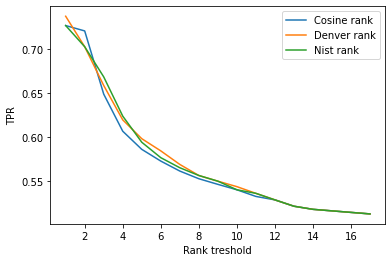

In [120]:
plt.plot(treshold, TPRc, label = "Cosine rank")
plt.plot(treshold, TPRd, label = "Denver rank")
plt.plot(treshold, TPRn, label = "Nist rank")

plt.legend()
plt.xlabel('Rank treshold')
plt.ylabel('TPR')
plt.savefig("syntTPvsFP.png",dpi=600)
plt.show()

Plot true-positive rate vs. relative rank threshold

In [121]:
rtreshold = np.linspace(0,1,11)
rtreshold

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [122]:
num_of_hits = list(range(len(data_norm)))
for i in range(len(data_norm)):
  #compute number of hits for each record
  num_of_hits[i] = len(data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'])

len(num_of_hits)
num_of_hits

[3,
 1,
 3,
 3,
 2,
 3,
 6,
 2,
 2,
 1,
 1,
 2,
 2,
 3,
 4,
 2,
 1,
 2,
 2,
 17,
 2,
 1,
 2,
 2,
 3,
 1,
 6,
 1,
 1,
 4,
 1,
 1,
 1,
 13,
 2,
 2,
 5,
 2,
 2,
 1,
 2,
 5,
 2,
 5,
 6,
 2,
 7,
 2,
 1,
 3,
 4,
 1,
 2,
 2,
 4,
 10,
 4,
 4,
 13,
 2,
 1,
 4,
 2,
 2,
 2,
 5,
 14,
 6,
 8,
 2,
 2,
 1,
 3,
 2,
 4,
 2,
 4,
 4,
 1,
 4,
 2,
 2,
 2,
 1,
 1,
 4,
 1,
 2,
 1,
 2,
 4,
 4,
 1,
 2,
 2]

In [123]:
it_cosine = iter(rrank_cosine)
sliced_cosine = [list(islice(it_cosine, 0, i)) for i in num_of_hits]
#sliced_cosine

In [124]:
it_denver = iter(rrank_denver)
sliced_denver = [list(islice(it_denver, 0, i)) for i in num_of_hits]
#sliced_denver

In [125]:
it_nist = iter(rrank_nist)
sliced_nist = [list(islice(it_nist, 0, i)) for i in num_of_hits]

In [126]:
TPRcr = list(range(len(rtreshold)))
TPRdr = list(range(len(rtreshold)))
TPRnr = list(range(len(rtreshold)))

for j in range(len(rtreshold)):
  TPcr = 0 #number of true-positive hits for cosine relative rank
  FPcr = 0 #number of false-positive hits for cosine relative rank
  TPdr = 0 #number of true-positive hits for denver relative rank
  FPdr = 0 #number of false-positive hits for denver relative rank
  TPnr = 0 #number of true-positive hits for nist relative rank
  FPnr = 0 #number of false-positive hits for nist relative rank
  for i in range(len(data_norm)):
    #compute number of hits for each record
    n_of_hits = n_of_hits = len(data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'])
    for k in range(n_of_hits):
      cosine_rrank = sliced_cosine[i][k]
      denver_rrank = sliced_denver[i][k]
      nist_rrank = sliced_nist[i][k]
      if(cosine_rrank <= rtreshold[j]):
        if(int(data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'][k]['InChIKey_hits']) == data['records'][i]['InChIKey']):
          TPcr = TPcr + 1
        else:
          FPcr = FPcr + 1
      if(denver_rrank <= rtreshold[j]):
        if(int(data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'][k]['InChIKey_hits']) == data['records'][i]['InChIKey']):
          TPdr = TPdr + 1
        else:
          FPdr = FPdr + 1
      if(nist_rrank <= rtreshold[j]):
        if(int(data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'][k]['InChIKey_hits']) == data['records'][i]['InChIKey']):
          TPnr = TPnr + 1
        else:
          FPnr = FPnr + 1

    TPRcr[j] = TPcr/(TPcr + FPcr)
    TPRdr[j] = TPdr/(TPdr + FPdr)
    TPRnr[j] = TPnr/(TPnr + FPnr)

#TPRcr
#TPRdr
#TPRnr


In [127]:
np.array((TPRcr,TPRdr,TPRnr)).T

array([[0.72631579, 0.73684211, 0.72631579],
       [0.6969697 , 0.70707071, 0.6969697 ],
       [0.66666667, 0.66666667, 0.65765766],
       [0.6446281 , 0.63636364, 0.62809917],
       [0.59183673, 0.59863946, 0.59863946],
       [0.5443787 , 0.55029586, 0.56804734],
       [0.51955307, 0.54748603, 0.54189944],
       [0.51243781, 0.53233831, 0.53731343],
       [0.49302326, 0.51162791, 0.51162791],
       [0.47533632, 0.49327354, 0.49327354],
       [0.51333333, 0.51333333, 0.51333333]])

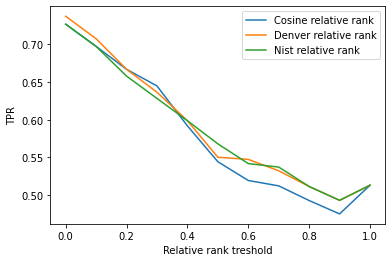

In [128]:
plt.plot(rtreshold, TPRcr, label = "Cosine relative rank")
plt.plot(rtreshold, TPRdr, label = "Denver relative rank")
plt.plot(rtreshold, TPRnr, label = "Nist relative rank")

plt.legend()
plt.xlabel('Relative rank treshold')
plt.ylabel('TPR')
plt.savefig("syntTPvsFPRelRank.png",dpi=600)
plt.show()